In [6]:
# ORCA — CMAPSS Predictive Maintenance (FD001–FD004)
# End-to-end, step-by-step, robust pipeline with clear prints for demo/presentation.

import os, json, math, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

DATA_DIR = "/content"

# Try XGBoost, fall back to RandomForest if unavailable (keeps the demo unblocked)
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
    MODEL_NAME = "XGBoostRegressor"
except Exception:
    from sklearn.ensemble import RandomForestRegressor
    HAS_XGB = False
    MODEL_NAME = "RandomForestRegressor"

# ---------- helper: pretty step prints ----------
def step(msg):
    print("\n" + "="*88)
    print(msg)
    print("="*88)

# ---------- robust loaders ----------
def load_cmapss_subset(fd_id, data_dir):
    """
    Load train/test/truth for FD00{fd_id}. Handles whitespace & extra empty cols.
    Returns (train_df, test_df, truth_df) with standardized column names.
    """
    train_path = os.path.join(data_dir, f"train_FD00{fd_id}.txt")
    test_path  = os.path.join(data_dir, f"test_FD00{fd_id}.txt")
    rul_path   = os.path.join(data_dir, f"RUL_FD00{fd_id}.txt")

    for p in [train_path, test_path, rul_path]:
        if not os.path.exists(p):
            raise FileNotFoundError(f"Required file missing: {p}")

    def read_matrix(path):
        # sep with regex handles variable whitespace; drop all-NaN columns
        df = pd.read_csv(path, sep=r"\s+", header=None, engine="python")
        df = df.dropna(axis=1, how="all")
        return df

    train = read_matrix(train_path)
    test  = read_matrix(test_path)
    truth = read_matrix(rul_path)

    expected_cols = 26  # unit, time, 3 op_settings, 21 sensors
    if train.shape[1] != expected_cols or test.shape[1] != expected_cols:
        raise ValueError(
            f"[FD00{fd_id}] Unexpected column count. Expected {expected_cols}, "
            f"got {train.shape[1]} (train) and {test.shape[1]} (test)."
        )

    cols = ["unit","time"] + [f"op_setting_{i}" for i in range(1,4)] + [f"sensor_{i}" for i in range(1,22)]
    train.columns = cols
    test.columns  = cols

    # Truth file: keep first col only, drop NaNs, reset index
    truth = truth.iloc[:, :1]
    truth.columns = ["truth_RUL"]
    truth = truth.dropna().reset_index(drop=True)
    return train, test, truth

# ---------- RUL construction ----------
def add_rul_train(train_df):
    """RUL = (max cycle for that unit) − (current time)."""
    train_df = train_df.copy()
    max_times = train_df.groupby("unit")["time"].transform("max")
    train_df["RUL"] = max_times - train_df["time"]
    return train_df

def add_rul_test(test_df, truth_df, fd_id):
    """
    Align test units with NASA truth RUL (given at last cycle per unit).
    EOL(unit) = last_cycle(unit) + truth_RUL(unit)
    Row RUL = EOL − current time
    """
    test_df = test_df.copy()
    units_sorted = np.sort(test_df["unit"].unique())
    last_cycles = (
        test_df.groupby("unit")["time"].max().reset_index().sort_values("unit").reset_index(drop=True)
    )

    if len(truth_df) != len(units_sorted):
        raise ValueError(
            f"[FD00{fd_id}] truth_RUL length ({len(truth_df)}) != number of test units ({len(units_sorted)})."
        )

    eol = last_cycles.copy()
    eol["truth_RUL"] = truth_df["truth_RUL"].values
    eol["EOL"] = eol["time"] + eol["truth_RUL"]
    eol = eol[["unit","EOL"]]

    test_df = test_df.merge(eol, on="unit", how="left")
    test_df["RUL"] = test_df["EOL"] - test_df["time"]
    test_df = test_df.drop(columns=["EOL"])
    return test_df

# ---------- features ----------
def select_features(df):
    return [c for c in df.columns if c.startswith("op_setting_") or c.startswith("sensor_")]

def drop_near_constant(train_df, feature_cols, std_threshold=1e-6):
    stds = train_df[feature_cols].std(axis=0)
    keep = [c for c in feature_cols if stds[c] > std_threshold]
    dropped = [c for c in feature_cols if c not in keep]
    return keep, dropped

# ---------- model ----------
def train_regressor(X_train, y_train):
    if HAS_XGB:
        model = XGBRegressor(
            n_estimators=300,      # fast & good baseline
            max_depth=6,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            tree_method="hist"    # GPU not required; fast on CPU
        )
    else:
        from sklearn.ensemble import RandomForestRegressor
        model = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    return model

# ---------- runner ----------
def run_fd(fd_id, data_dir, outputs_dir):
    step(f"[FD00{fd_id}] STEP 1 — Load data")
    train_df, test_df, truth_df = load_cmapss_subset(fd_id, data_dir)
    print(f"Train shape: {train_df.shape}")
    print(f"Test  shape: {test_df.shape}")
    print(f"Truth rows:  {truth_df.shape[0]} (one per test unit)")

    step(f"[FD00{fd_id}] STEP 2 — Build RUL labels")
    train_df = add_rul_train(train_df)
    test_df  = add_rul_test(test_df, truth_df, fd_id)
    print("✓ RUL labels attached to train & test.")

    step(f"[FD00{fd_id}] STEP 3 — Feature selection & variance filter")
    feature_cols = select_features(train_df)
    feature_cols, dropped = drop_near_constant(train_df, feature_cols)
    print(f"Using {len(feature_cols)} features. Dropped {len(dropped)} near-constant: {dropped}")

    step(f"[FD00{fd_id}] STEP 4 — Scale features (MinMax)")
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(train_df[feature_cols])
    y_train = train_df["RUL"].values
    X_test  = scaler.transform(test_df[feature_cols])
    y_test  = test_df["RUL"].values
    print(f"X_train: {X_train.shape} | X_test: {X_test.shape} | Model: {MODEL_NAME}")

    step(f"[FD00{fd_id}] STEP 5 — Train model")
    model = train_regressor(X_train, y_train)
    print("✓ Training complete.")

    step(f"[FD00{fd_id}] STEP 6 — Predict & evaluate")
    y_pred = model.predict(X_test)
    mae  = mean_absolute_error(y_test, y_pred)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print(f"MAE  (cycles): {mae:.2f}")
    print(f"RMSE (cycles): {rmse:.2f}")

    step(f"[FD00{fd_id}] STEP 7 — Visualize (first 500 points)")
    plots_dir   = os.path.join(outputs_dir, "plots")
    models_dir  = os.path.join(outputs_dir, "models")
    scalers_dir = os.path.join(outputs_dir, "scalers")
    meta_dir    = os.path.join(outputs_dir, "meta")
    for d in [plots_dir, models_dir, scalers_dir, meta_dir]:
        os.makedirs(d, exist_ok=True)

    plt.figure(figsize=(12,4))
    n_plot = min(500, len(y_test))
    plt.plot(np.arange(n_plot), y_test[:n_plot], label="True RUL")
    plt.plot(np.arange(n_plot), y_pred[:n_plot], label="Predicted RUL")
    plt.title(f"FD00{fd_id} — RUL (first {n_plot} points)")
    plt.legend()
    plot_path = os.path.join(plots_dir, f"FD00{fd_id}_rul_plot.png")
    plt.savefig(plot_path, bbox_inches="tight"); plt.close()
    print(f"✓ Plot saved → {plot_path}")

    step(f"[FD00{fd_id}] STEP 8 — Save artifacts")
    model_path    = os.path.join(models_dir,  f"FD00{fd_id}_{MODEL_NAME}.pkl")
    scaler_path   = os.path.join(scalers_dir, f"FD00{fd_id}_MinMaxScaler.pkl")
    features_path = os.path.join(meta_dir,    f"FD00{fd_id}_features.json")
    joblib.dump(model, model_path)
    joblib.dump(scaler, scaler_path)
    with open(features_path, "w") as f:
        json.dump({"features": feature_cols, "model": MODEL_NAME}, f, indent=2)
    print(f"✓ Model    → {model_path}")
    print(f"✓ Scaler   → {scaler_path}")
    print(f"✓ Features → {features_path}")

    return {
        "FD": f"FD00{fd_id}",
        "Algorithm": MODEL_NAME,
        "n_train_rows": len(train_df),
        "n_test_rows": len(test_df),
        "n_features": len(feature_cols),
        "MAE_cycles": round(mae, 3),
        "RMSE_cycles": round(rmse, 3),
        "plot_path": plot_path,
        "model_path": model_path,
        "scaler_path": scaler_path,
        "features_path": features_path
    }

# ---------- run all ----------
outputs_dir = "/content/orca_outputs"  # change if you prefer
os.makedirs(outputs_dir, exist_ok=True)

all_results = []
for fd in [1,2,3,4]:
    try:
        res = run_fd(fd, DATA_DIR, outputs_dir)
        all_results.append(res)
    except Exception as e:
        step(f"[FD00{fd}] ERROR — Skipping due to: {e}")
        all_results.append({
            "FD": f"FD00{fd}", "Algorithm": MODEL_NAME,
            "n_train_rows": None, "n_test_rows": None, "n_features": None,
            "MAE_cycles": None, "RMSE_cycles": None,
            "plot_path": None, "model_path": None, "scaler_path": None, "features_path": None,
            "error": str(e)
        })

# ---------- summary ----------
summary_df = pd.DataFrame(all_results)
summary_csv = os.path.join(outputs_dir, "cmapss_results_summary.csv")
summary_df.to_csv(summary_csv, index=False)

step("SUMMARY — FD001..FD004")
print(summary_df)
print(f"\nSummary saved → {summary_csv}")
print(f"Artifacts (plots/models/scalers/meta) → {outputs_dir}")


[FD001] STEP 1 — Load data
Train shape: (20631, 26)
Test  shape: (13096, 26)
Truth rows:  100 (one per test unit)

[FD001] STEP 2 — Build RUL labels
✓ RUL labels attached to train & test.

[FD001] STEP 3 — Feature selection & variance filter
Using 17 features. Dropped 7 near-constant: ['op_setting_3', 'sensor_1', 'sensor_5', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']

[FD001] STEP 4 — Scale features (MinMax)
X_train: (20631, 17) | X_test: (13096, 17) | Model: XGBoostRegressor

[FD001] STEP 5 — Train model
✓ Training complete.

[FD001] STEP 6 — Predict & evaluate
MAE  (cycles): 34.73
RMSE (cycles): 46.23

[FD001] STEP 7 — Visualize (first 500 points)
✓ Plot saved → /content/orca_outputs/plots/FD001_rul_plot.png

[FD001] STEP 8 — Save artifacts
✓ Model    → /content/orca_outputs/models/FD001_XGBoostRegressor.pkl
✓ Scaler   → /content/orca_outputs/scalers/FD001_MinMaxScaler.pkl
✓ Features → /content/orca_outputs/meta/FD001_features.json

[FD002] STEP 1 — Load data
Train shape: (

In [7]:
# =====================================================
# ORCA — Deep Learning Model (CNN + LSTM) for RUL
# =====================================================
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math, os, json, joblib
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# Sequence data prep function
# ---------------------------
def make_sequences(df, feature_cols, seq_len=30):
    """
    Converts dataframe into overlapping sequences for CNN+LSTM.
    Each sequence length = seq_len, target = RUL at last step.
    Returns X (3D tensor), y (1D vector).
    """
    X, y = [], []
    for unit in df["unit"].unique():
        unit_df = df[df["unit"] == unit].reset_index(drop=True)
        feats = unit_df[feature_cols].values
        rul   = unit_df["RUL"].values
        for i in range(len(unit_df) - seq_len + 1):
            X.append(feats[i:i+seq_len])
            y.append(rul[i+seq_len-1])
    return np.array(X), np.array(y)

# ---------------------------
# Model builder
# ---------------------------
def build_cnn_lstm(input_shape):
    model = models.Sequential([
        layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        layers.Conv1D(64, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.LSTM(64, return_sequences=False),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)  # RUL regression
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')
    return model

# ---------------------------
# Runner for FD datasets
# ---------------------------
def run_fd_deep(fd_id, data_dir, outputs_dir, seq_len=30, epochs=20, batch_size=128):
    print("\n" + "="*88)
    print(f"[FD00{fd_id}] Deep Model (CNN+LSTM)")
    print("="*88)

    # STEP 1 — Load
    train_df, test_df, truth_df = load_cmapss_subset(fd_id, data_dir)
    train_df = add_rul_train(train_df)
    test_df  = add_rul_test(test_df, truth_df, fd_id)

    # STEP 2 — Feature selection
    feature_cols = select_features(train_df)
    feature_cols, _ = drop_near_constant(train_df, feature_cols)

    # STEP 3 — Scale
    scaler = MinMaxScaler()
    train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
    test_df[feature_cols]  = scaler.transform(test_df[feature_cols])

    # STEP 4 — Make sequences
    X_train, y_train = make_sequences(train_df, feature_cols, seq_len=seq_len)
    X_test, y_test   = make_sequences(test_df, feature_cols, seq_len=seq_len)
    print(f"Train seqs: {X_train.shape}, Test seqs: {X_test.shape}")

    # STEP 5 — Build model
    model = build_cnn_lstm((seq_len, len(feature_cols)))
    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2
    )

    # STEP 6 — Evaluate
    y_pred = model.predict(X_test).flatten()
    mae  = mean_absolute_error(y_test, y_pred)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print(f"MAE  (cycles): {mae:.2f}")
    print(f"RMSE (cycles): {rmse:.2f}")

    # STEP 7 — Plot
    plots_dir = os.path.join(outputs_dir, "plots_deep")
    models_dir = os.path.join(outputs_dir, "models_deep")
    scalers_dir = os.path.join(outputs_dir, "scalers_deep")
    meta_dir = os.path.join(outputs_dir, "meta_deep")
    for d in [plots_dir, models_dir, scalers_dir, meta_dir]:
        os.makedirs(d, exist_ok=True)

    plt.figure(figsize=(12,4))
    n_plot = min(500, len(y_test))
    plt.plot(np.arange(n_plot), y_test[:n_plot], label="True RUL")
    plt.plot(np.arange(n_plot), y_pred[:n_plot], label="Predicted RUL")
    plt.title(f"FD00{fd_id} — CNN+LSTM RUL (first {n_plot} points)")
    plt.legend()
    plot_path = os.path.join(plots_dir, f"FD00{fd_id}_cnn_lstm_rul.png")
    plt.savefig(plot_path, bbox_inches="tight"); plt.close()

    # STEP 8 — Save artifacts
    model_path    = os.path.join(models_dir,  f"FD00{fd_id}_CNN_LSTM.h5")
    scaler_path   = os.path.join(scalers_dir, f"FD00{fd_id}_MinMaxScaler.pkl")
    features_path = os.path.join(meta_dir,    f"FD00{fd_id}_features.json")

    model.save(model_path)
    joblib.dump(scaler, scaler_path)
    with open(features_path, "w") as f:
        json.dump({"features": feature_cols, "model": "CNN+LSTM"}, f, indent=2)

    return {
        "FD": f"FD00{fd_id}",
        "Algorithm": "CNN+LSTM",
        "n_train_seqs": len(X_train),
        "n_test_seqs": len(X_test),
        "seq_len": seq_len,
        "n_features": len(feature_cols),
        "MAE_cycles": round(mae, 3),
        "RMSE_cycles": round(rmse, 3),
        "plot_path": plot_path,
        "model_path": model_path,
        "scaler_path": scaler_path,
        "features_path": features_path
    }

# ---------------------------
# Run all FD sets
# ---------------------------
deep_results = []
for fd in [1,2,3,4]:
    try:
        res = run_fd_deep(fd, DATA_DIR, outputs_dir, seq_len=30, epochs=20, batch_size=128)
        deep_results.append(res)
    except Exception as e:
        print(f"[FD00{fd}] ERROR: {e}")
        deep_results.append({
            "FD": f"FD00{fd}", "Algorithm": "CNN+LSTM",
            "n_train_seqs": None, "n_test_seqs": None, "seq_len": None,
            "n_features": None, "MAE_cycles": None, "RMSE_cycles": None,
            "plot_path": None, "model_path": None, "scaler_path": None, "features_path": None,
            "error": str(e)
        })

# Save summary
deep_summary_df = pd.DataFrame(deep_results)
deep_summary_csv = os.path.join(outputs_dir, "cmapss_results_summary_deep.csv")
deep_summary_df.to_csv(deep_summary_csv, index=False)

print("\nSUMMARY — CNN+LSTM FD001..FD004")
print(deep_summary_df)
print(f"\nSummary saved → {deep_summary_csv}")



[FD001] Deep Model (CNN+LSTM)
Train seqs: (17731, 30, 17), Test seqs: (10196, 30, 17)
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 - 4s - 32ms/step - loss: 8122.0566 - val_loss: 6326.9097
Epoch 2/20
125/125 - 1s - 7ms/step - loss: 3626.4753 - val_loss: 4552.4497
Epoch 3/20
125/125 - 1s - 9ms/step - loss: 2070.1462 - val_loss: 2317.5837
Epoch 4/20
125/125 - 1s - 12ms/step - loss: 1368.3818 - val_loss: 1864.3962
Epoch 5/20
125/125 - 1s - 8ms/step - loss: 1199.7173 - val_loss: 2010.5101
Epoch 6/20
125/125 - 1s - 7ms/step - loss: 1063.7257 - val_loss: 1995.2959
Epoch 7/20
125/125 - 1s - 7ms/step - loss: 971.1866 - val_loss: 1662.2865
Epoch 8/20
125/125 - 1s - 10ms/step - loss: 941.5126 - val_loss: 1874.2874
Epoch 9/20
125/125 - 1s - 7ms/step - loss: 900.6820 - val_loss: 1744.1619
Epoch 10/20
125/125 - 1s - 10ms/step - loss: 875.8449 - val_loss: 1725.4957
Epoch 11/20
125/125 - 1s - 7ms/step - loss: 881.7946 - val_loss: 1653.0157
Epoch 12/20
125/125 - 1s - 8ms/step - loss: 848.2192 - val_loss: 1813.5505
Epoch 13/20
125/125 - 1s - 8ms/step - loss: 816.2284 - val_loss: 1532.2189
Epoch 14/20
125/125 - 1s - 8ms/step


[FD002] Deep Model (CNN+LSTM)
Train seqs: (46219, 30, 24), Test seqs: (26505, 30, 24)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
325/325 - 6s - 19ms/step - loss: 5490.8970 - val_loss: 4812.3428
Epoch 2/20
325/325 - 2s - 7ms/step - loss: 3769.7522 - val_loss: 4844.4971
Epoch 3/20
325/325 - 3s - 8ms/step - loss: 3769.6279 - val_loss: 4815.4990
Epoch 4/20
325/325 - 3s - 9ms/step - loss: 3769.0027 - val_loss: 4817.6851
Epoch 5/20
325/325 - 2s - 7ms/step - loss: 3188.9441 - val_loss: 2869.1458
Epoch 6/20
325/325 - 3s - 8ms/step - loss: 2089.1321 - val_loss: 2752.0364
Epoch 7/20
325/325 - 2s - 7ms/step - loss: 1785.3789 - val_loss: 2000.7468
Epoch 8/20
325/325 - 2s - 7ms/step - loss: 1621.9293 - val_loss: 2023.6125
Epoch 9/20
325/325 - 3s - 9ms/step - loss: 1571.5127 - val_loss: 1820.8538
Epoch 10/20
325/325 - 5s - 14ms/step - loss: 1520.1238 - val_loss: 1819.9656
Epoch 11/20
325/325 - 2s - 7ms/step - loss: 1484.1230 - val_loss: 2059.0330
Epoch 12/20
325/325 - 3s - 8ms/step - loss: 1429.1029 - val_loss: 1857.3667
Epoch 13/20
325/325 - 3s - 9ms/step - loss: 1428.7927 - val_loss: 1988.1309
Epoch 14/20
325/325

MAE  (cycles): 38.06
RMSE (cycles): 49.74

[FD003] Deep Model (CNN+LSTM)
Train seqs: (21820, 30, 18), Test seqs: (13696, 30, 18)
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


154/154 - 4s - 24ms/step - loss: 16534.2402 - val_loss: 13445.3623
Epoch 2/20
154/154 - 2s - 13ms/step - loss: 8033.7485 - val_loss: 10654.8564
Epoch 3/20
154/154 - 1s - 8ms/step - loss: 5693.3750 - val_loss: 7695.6416
Epoch 4/20
154/154 - 1s - 9ms/step - loss: 3079.7805 - val_loss: 8192.4170
Epoch 5/20
154/154 - 2s - 15ms/step - loss: 2756.4067 - val_loss: 6912.1846
Epoch 6/20
154/154 - 1s - 8ms/step - loss: 2635.9553 - val_loss: 7163.4136
Epoch 7/20
154/154 - 1s - 8ms/step - loss: 2527.4856 - val_loss: 6376.3311
Epoch 8/20
154/154 - 1s - 8ms/step - loss: 2412.7710 - val_loss: 6716.0933
Epoch 9/20
154/154 - 1s - 9ms/step - loss: 2323.1270 - val_loss: 5407.8105
Epoch 10/20
154/154 - 1s - 7ms/step - loss: 2176.0642 - val_loss: 5527.8804
Epoch 11/20
154/154 - 1s - 8ms/step - loss: 2094.8940 - val_loss: 4276.5938
Epoch 12/20
154/154 - 1s - 8ms/step - loss: 2010.6628 - val_loss: 4443.7686
Epoch 13/20
154/154 - 2s - 16ms/step - loss: 1966.8500 - val_loss: 5354.6973
Epoch 14/20
154/154 - 1s 


[FD004] Deep Model (CNN+LSTM)
Train seqs: (54028, 30, 24), Test seqs: (34081, 30, 24)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
380/380 - 5s - 14ms/step - loss: 10203.0928 - val_loss: 5822.3193
Epoch 2/20
380/380 - 5s - 12ms/step - loss: 7103.0845 - val_loss: 5817.7251
Epoch 3/20
380/380 - 3s - 7ms/step - loss: 7103.3999 - val_loss: 5827.9058
Epoch 4/20
380/380 - 5s - 14ms/step - loss: 7103.4761 - val_loss: 5809.8447
Epoch 5/20
380/380 - 5s - 13ms/step - loss: 7103.1709 - val_loss: 5832.4614
Epoch 6/20
380/380 - 3s - 7ms/step - loss: 7104.3213 - val_loss: 5810.8804
Epoch 7/20
380/380 - 3s - 7ms/step - loss: 7102.7905 - val_loss: 5793.2871
Epoch 8/20
380/380 - 5s - 13ms/step - loss: 7105.3828 - val_loss: 5824.3301
Epoch 9/20
380/380 - 5s - 13ms/step - loss: 7104.2617 - val_loss: 5822.2749
Epoch 10/20
380/380 - 3s - 8ms/step - loss: 7104.6553 - val_loss: 5849.6948
Epoch 11/20
380/380 - 3s - 8ms/step - loss: 7103.6177 - val_loss: 5818.3740
Epoch 12/20
380/380 - 5s - 13ms/step - loss: 7106.2568 - val_loss: 5812.4966
Epoch 13/20
380/380 - 6s - 15ms/step - loss: 7105.0122 - val_loss: 5818.3740
Epoch 14/20


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:570: RuntimeWarning: overflow encountered in square
  output_errors = _average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)


MAE  (cycles): 77.12
RMSE (cycles): inf

SUMMARY — CNN+LSTM FD001..FD004
      FD Algorithm  n_train_seqs  n_test_seqs  seq_len  n_features  \
0  FD001  CNN+LSTM         17731        10196       30          17   
1  FD002  CNN+LSTM         46219        26505       30          24   
2  FD003  CNN+LSTM         21820        13696       30          18   
3  FD004  CNN+LSTM         54028        34081       30          24   

   MAE_cycles  RMSE_cycles                                          plot_path  \
0      30.141       41.473  /content/orca_outputs/plots_deep/FD001_cnn_lst...   
1      38.062       49.739  /content/orca_outputs/plots_deep/FD002_cnn_lst...   
2      41.781       59.414  /content/orca_outputs/plots_deep/FD003_cnn_lst...   
3      77.125          inf  /content/orca_outputs/plots_deep/FD004_cnn_lst...   

                                          model_path  \
0  /content/orca_outputs/models_deep/FD001_CNN_LS...   
1  /content/orca_outputs/models_deep/FD002_CNN_LS...   
2 

In [8]:
# =====================================================
# ORCA — CNN + BiLSTM + Attention (Self-Attention via MultiHeadAttention)
# Drop-in cell: reuses loaders from your notebook
# =====================================================
import os, math, json, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Optional: enable mixed precision for faster T4 runs (comment out if issues)
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy("mixed_float16")
    MIXED_PRECISION = True
    print("Mixed precision ENABLED")
except Exception:
    MIXED_PRECISION = False
    print("Mixed precision NOT available")

# ---------- sequence maker (same style as before) ----------
def make_sequences(df, feature_cols, seq_len=30):
    X, y = [], []
    for unit in df["unit"].unique():
        unit_df = df[df["unit"] == unit].reset_index(drop=True)
        feats = unit_df[feature_cols].values
        rul   = unit_df["RUL"].values
        for i in range(len(unit_df) - seq_len + 1):
            X.append(feats[i:i+seq_len])
            y.append(rul[i+seq_len-1])
    return np.array(X), np.array(y)

# ---------- model builder: CNN + BiLSTM + MultiHeadAttention ----------
def build_cnn_bilstm_attention(input_shape,
                               conv_filters=64,
                               lstm_units=64,
                               num_heads=4,
                               key_dim=32,
                               dense_units=64,
                               dropout=0.2):
    inp = Input(shape=input_shape, name="sequence_input")
    # Conv block
    x = layers.Conv1D(conv_filters, 3, padding="same", activation="relu")(inp)
    x = layers.Conv1D(conv_filters, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    # BiLSTM (return sequences for attention)
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(x)
    # Self-attention (MultiHeadAttention expects float32; handle mixed precision)
    # If mixed precision is enabled, cast to float32 for attention then back.
    if MIXED_PRECISION:
        x = layers.Activation("linear", dtype="float32")(x)
    attn_out = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = layers.Add()([x, attn_out])  # residual connection
    x = layers.LayerNormalization()(x)
    # Pool and dense head
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(dense_units, activation="relu")(x)
    if MIXED_PRECISION:
        # final dense in float32 to stabilize output; Keras will handle dtype casting
        x = layers.Dense(1, dtype="float32")(x)
    else:
        x = layers.Dense(1)(x)
    model = models.Model(inputs=inp, outputs=x, name="CNN_BiLSTM_Attn")
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=opt, loss="mse", metrics=[tf.keras.metrics.MeanAbsoluteError()])
    return model

# ---------- runner per FD ----------
def run_fd_attention(fd_id, data_dir, outputs_dir, seq_len=30, epochs=30, batch_size=128):
    step_header = f"[FD00{fd_id}] CNN+BiLSTM+Attention"
    print("\n" + "="*88 + "\n" + step_header + "\n" + "="*88)
    train_df, test_df, truth_df = load_cmapss_subset(fd_id, data_dir)
    train_df = add_rul_train(train_df)
    test_df  = add_rul_test(test_df, truth_df, fd_id)

    # features
    feature_cols = select_features(train_df)
    feature_cols, dropped = drop_near_constant(train_df, feature_cols)
    print(f"Using {len(feature_cols)} features — dropped: {dropped}")

    # scale (fit on train)
    scaler = MinMaxScaler()
    train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
    test_df[feature_cols]  = scaler.transform(test_df[feature_cols])

    # sequences
    X_train, y_train = make_sequences(train_df, feature_cols, seq_len=seq_len)
    X_test,  y_test  = make_sequences(test_df, feature_cols, seq_len=seq_len)
    print(f"Train seqs: {X_train.shape}, Test seqs: {X_test.shape}")

    # build model
    model = build_cnn_bilstm_attention((seq_len, len(feature_cols)),
                                      conv_filters=64, lstm_units=64,
                                      num_heads=4, key_dim=32, dense_units=64, dropout=0.2)

    model.summary()

    # callbacks
    models_dir = os.path.join(outputs_dir, "models_attn")
    plots_dir  = os.path.join(outputs_dir, "plots_attn")
    scalers_dir = os.path.join(outputs_dir, "scalers_attn")
    meta_dir    = os.path.join(outputs_dir, "meta_attn")
    for d in [models_dir, plots_dir, scalers_dir, meta_dir]:
        os.makedirs(d, exist_ok=True)

    model_path = os.path.join(models_dir, f"FD00{fd_id}_CNN_BiLSTM_Attn.keras")
    checkpoint = callbacks.ModelCheckpoint(model_path, monitor="val_loss", save_best_only=True, verbose=1)
    earlystop  = callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)
    reduce_lr  = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1, min_lr=1e-6)

    # train
    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[checkpoint, earlystop, reduce_lr],
        verbose=2
    )

    # load best model (ModelCheckpoint saved .keras)
    model = tf.keras.models.load_model(model_path)

    # predict + eval
    y_pred = model.predict(X_test).flatten()
    mae  = mean_absolute_error(y_test, y_pred)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print(f"MAE  (cycles): {mae:.2f}")
    print(f"RMSE (cycles): {rmse:.2f}")

    # plot
    n_plot = min(500, len(y_test))
    plt.figure(figsize=(12,4))
    plt.plot(np.arange(n_plot), y_test[:n_plot], label="True RUL")
    plt.plot(np.arange(n_plot), y_pred[:n_plot], label="Predicted RUL")
    plt.title(f"FD00{fd_id} — CNN+BiLSTM+Attn RUL (first {n_plot})")
    plt.legend()
    plot_path = os.path.join(plots_dir, f"FD00{fd_id}_cnn_bilstm_attn_rul.png")
    plt.savefig(plot_path, bbox_inches="tight"); plt.close()

    # save scaler & features
    scaler_path   = os.path.join(scalers_dir, f"FD00{fd_id}_MinMaxScaler.pkl")
    features_path = os.path.join(meta_dir,    f"FD00{fd_id}_features.json")
    joblib.dump(scaler, scaler_path)
    with open(features_path, "w") as f:
        json.dump({"features": feature_cols, "model": "CNN+BiLSTM+Attention"}, f, indent=2)

    return {
        "FD": f"FD00{fd_id}",
        "Algorithm": "CNN+BiLSTM+Attention",
        "n_train_seqs": len(X_train),
        "n_test_seqs": len(X_test),
        "seq_len": seq_len,
        "n_features": len(feature_cols),
        "MAE_cycles": round(mae,3),
        "RMSE_cycles": round(rmse,3),
        "plot_path": plot_path,
        "model_path": model_path,
        "scaler_path": scaler_path,
        "features_path": features_path
    }

# ---------- run across FD001..FD004 ----------
outputs_dir = os.path.join("/content", "orca_outputs")
os.makedirs(outputs_dir, exist_ok=True)

attn_results = []
for fd in [1,2,3,4]:
    try:
        res = run_fd_attention(fd, DATA_DIR, outputs_dir, seq_len=30, epochs=30, batch_size=128)
        attn_results.append(res)
    except Exception as e:
        print(f"[FD00{fd}] ERROR: {e}")
        attn_results.append({
            "FD": f"FD00{fd}", "Algorithm": "CNN+BiLSTM+Attention",
            "n_train_seqs": None, "n_test_seqs": None, "seq_len": None,
            "n_features": None, "MAE_cycles": None, "RMSE_cycles": None,
            "plot_path": None, "model_path": None, "scaler_path": None, "features_path": None,
            "error": str(e)
        })

attn_df = pd.DataFrame(attn_results)
attn_csv = os.path.join(outputs_dir, "cmapss_results_summary_attn.csv")
attn_df.to_csv(attn_csv, index=False)
print("\nSUMMARY — CNN+BiLSTM+Attention FD001..FD004")
print(attn_df)
print(f"\nSummary saved → {attn_csv}")

Mixed precision ENABLED

[FD001] CNN+BiLSTM+Attention
Using 17 features — dropped: ['op_setting_3', 'sensor_1', 'sensor_5', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
Train seqs: (17731, 30, 17), Test seqs: (10196, 30, 17)


Model: "CNN_BiLSTM_Attn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence_input      │ (None, 30, 17)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 30, 64)    │      3,328 │ sequence_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 30, 64)    │     12,352 │ conv1d_24[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_12    │ (None, 15, 64)    │          0 │ conv1d_25[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 15, 128)   │     66,048 │ max_pooling1d_12… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 15, 128)   │          0 │ bidirectional_4[… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 128)   │     66,048 │ activation_4[0][… │
│ (MultiHeadAttentio… │                   │            │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 15, 128)   │          0 │ activation_4[0][… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 128)       │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 64)        │      8,256 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 1)         │         65 │ dense_24[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 156,353 (610.75 KB)

 Trainable params: 156,353 (610.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30

Epoch 1: val_loss improved from inf to 3315.86719, saving model to /content/orca_outputs/models_attn/FD001_CNN_BiLSTM_Attn.keras
125/125 - 8s - 62ms/step - loss: 5657.6909 - mean_absolute_error: 57.6181 - val_loss: 3315.8672 - val_mean_absolute_error: 41.7040 - learning_rate: 1.0000e-03
Epoch 2/30

Epoch 2: val_loss improved from 3315.86719 to 1701.58228, saving model to /content/orca_outputs/models_attn/FD001_CNN_BiLSTM_Attn.keras
125/125 - 2s - 15ms/step - loss: 1460.8635 - mean_absolute_error: 27.1258 - val_loss: 1701.5823 - val_mean_absolute_error: 29.5577 - learning_rate: 1.0000e-03
Epoch 3/30

Epoch 3: val_loss did not improve from 1701.58228
125/125 - 2s - 14ms/step - loss: 1015.0297 - mean_absolute_error: 21.7941 - val_loss: 2013.7535 - val_mean_absolute_error: 29.0129 - learning_rate: 1.0000e-03
Epoch 4/30

Epoch 4: val_loss improved from 1701.58228 to 1507.26245, saving model to /content/orca_outputs/models_attn/FD001_CNN_BiLSTM_Attn.keras
125/125 - 2s - 15ms/step

Model: "CNN_BiLSTM_Attn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence_input      │ (None, 30, 24)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 30, 64)    │      4,672 │ sequence_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 30, 64)    │     12,352 │ conv1d_26[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_13    │ (None, 15, 64)    │          0 │ conv1d_27[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 15, 128)   │     66,048 │ max_pooling1d_13… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 15, 128)   │          0 │ bidirectional_5[… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 128)   │     66,048 │ activation_5[0][… │
│ (MultiHeadAttentio… │                   │            │ activation_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 15, 128)   │          0 │ activation_5[0][… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 128)       │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 64)        │      8,256 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 1)         │         65 │ dense_26[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 157,697 (616.00 KB)

 Trainable params: 157,697 (616.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30

Epoch 1: val_loss improved from inf to 4774.65088, saving model to /content/orca_outputs/models_attn/FD002_CNN_BiLSTM_Attn.keras
325/325 - 10s - 30ms/step - loss: 4858.4517 - mean_absolute_error: 55.1508 - val_loss: 4774.6509 - val_mean_absolute_error: 56.2231 - learning_rate: 1.0000e-03
Epoch 2/30

Epoch 2: val_loss improved from 4774.65088 to 3436.82349, saving model to /content/orca_outputs/models_attn/FD002_CNN_BiLSTM_Attn.keras
325/325 - 4s - 13ms/step - loss: 3701.2178 - mean_absolute_error: 49.3360 - val_loss: 3436.8235 - val_mean_absolute_error: 44.5520 - learning_rate: 1.0000e-03
Epoch 3/30

Epoch 3: val_loss improved from 3436.82349 to 2562.46118, saving model to /content/orca_outputs/models_attn/FD002_CNN_BiLSTM_Attn.keras
325/325 - 4s - 13ms/step - loss: 2411.2507 - mean_absolute_error: 37.4205 - val_loss: 2562.4612 - val_mean_absolute_error: 39.6868 - learning_rate: 1.0000e-03
Epoch 4/30

Epoch 4: val_loss improved from 2562.46118 to 2126.43994, saving model to

Model: "CNN_BiLSTM_Attn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence_input      │ (None, 30, 18)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 30, 64)    │      3,520 │ sequence_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 30, 64)    │     12,352 │ conv1d_28[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_14    │ (None, 15, 64)    │          0 │ conv1d_29[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 15, 128)   │     66,048 │ max_pooling1d_14… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 15, 128)   │          0 │ bidirectional_6[… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 128)   │     66,048 │ activation_6[0][… │
│ (MultiHeadAttentio… │                   │            │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 15, 128)   │          0 │ activation_6[0][… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_6[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 128)       │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 64)        │      8,256 │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 1)         │         65 │ dense_28[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 156,545 (611.50 KB)

 Trainable params: 156,545 (611.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30

Epoch 1: val_loss improved from inf to 8855.92773, saving model to /content/orca_outputs/models_attn/FD003_CNN_BiLSTM_Attn.keras
154/154 - 8s - 53ms/step - loss: 13206.6699 - mean_absolute_error: 85.3859 - val_loss: 8855.9277 - val_mean_absolute_error: 61.9885 - learning_rate: 1.0000e-03
Epoch 2/30

Epoch 2: val_loss improved from 8855.92773 to 7166.95215, saving model to /content/orca_outputs/models_attn/FD003_CNN_BiLSTM_Attn.keras
154/154 - 2s - 14ms/step - loss: 3382.1658 - mean_absolute_error: 39.4043 - val_loss: 7166.9521 - val_mean_absolute_error: 52.5762 - learning_rate: 1.0000e-03
Epoch 3/30

Epoch 3: val_loss improved from 7166.95215 to 3924.92212, saving model to /content/orca_outputs/models_attn/FD003_CNN_BiLSTM_Attn.keras
154/154 - 2s - 16ms/step - loss: 2402.4016 - mean_absolute_error: 33.6843 - val_loss: 3924.9221 - val_mean_absolute_error: 41.8187 - learning_rate: 1.0000e-03
Epoch 4/30

Epoch 4: val_loss did not improve from 3924.92212
154/154 - 3s - 16ms/ste

Model: "CNN_BiLSTM_Attn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence_input      │ (None, 30, 24)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 30, 64)    │      4,672 │ sequence_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 30, 64)    │     12,352 │ conv1d_30[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_15    │ (None, 15, 64)    │          0 │ conv1d_31[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 15, 128)   │     66,048 │ max_pooling1d_15… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 15, 128)   │          0 │ bidirectional_7[… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 128)   │     66,048 │ activation_7[0][… │
│ (MultiHeadAttentio… │                   │            │ activation_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 15, 128)   │          0 │ activation_7[0][… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_7[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 128)       │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 64)        │      8,256 │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 1)         │         65 │ dense_30[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 157,697 (616.00 KB)

 Trainable params: 157,697 (616.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30

Epoch 1: val_loss improved from inf to 5899.40820, saving model to /content/orca_outputs/models_attn/FD004_CNN_BiLSTM_Attn.keras
380/380 - 10s - 26ms/step - loss: 8981.7432 - mean_absolute_error: 73.7531 - val_loss: 5899.4082 - val_mean_absolute_error: 63.9600 - learning_rate: 1.0000e-03
Epoch 2/30

Epoch 2: val_loss improved from 5899.40820 to 3285.48389, saving model to /content/orca_outputs/models_attn/FD004_CNN_BiLSTM_Attn.keras
380/380 - 10s - 25ms/step - loss: 5156.5205 - mean_absolute_error: 54.8156 - val_loss: 3285.4839 - val_mean_absolute_error: 42.3251 - learning_rate: 1.0000e-03
Epoch 3/30

Epoch 3: val_loss improved from 3285.48389 to 2872.48657, saving model to /content/orca_outputs/models_attn/FD004_CNN_BiLSTM_Attn.keras
380/380 - 6s - 15ms/step - loss: 3532.7148 - mean_absolute_error: 43.7181 - val_loss: 2872.4866 - val_mean_absolute_error: 41.9183 - learning_rate: 1.0000e-03
Epoch 4/30

Epoch 4: val_loss improved from 2872.48657 to 2709.68140, saving model t

Has baseline keys: ['FD001', 'FD002', 'FD003', 'FD004']
Has cnn_lstm keys: ['FD001', 'FD002', 'FD003', 'FD004']
Has attn keys: ['FD001', 'FD002', 'FD003', 'FD004']

Comparison table (MAE):


Model,Baseline,BiLSTM+Attention,CNN+LSTM
FD,,,
FD001,34.730,26.505,30.141
FD002,38.440,36.638,38.062
FD003,50.512,43.694,41.781
FD004,53.104,55.159,77.125


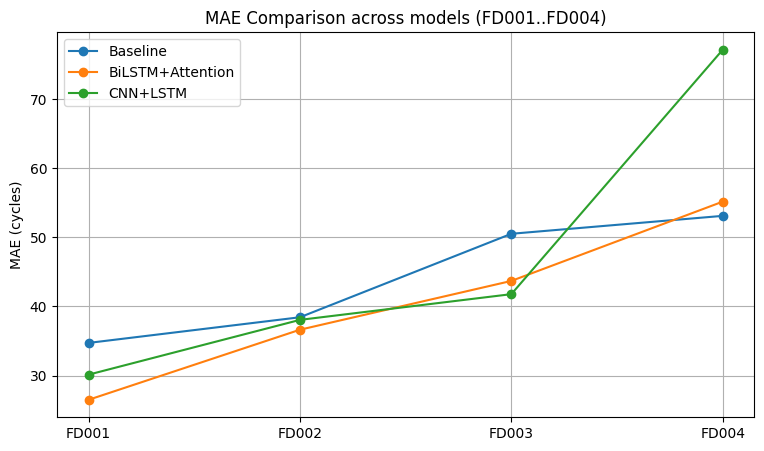

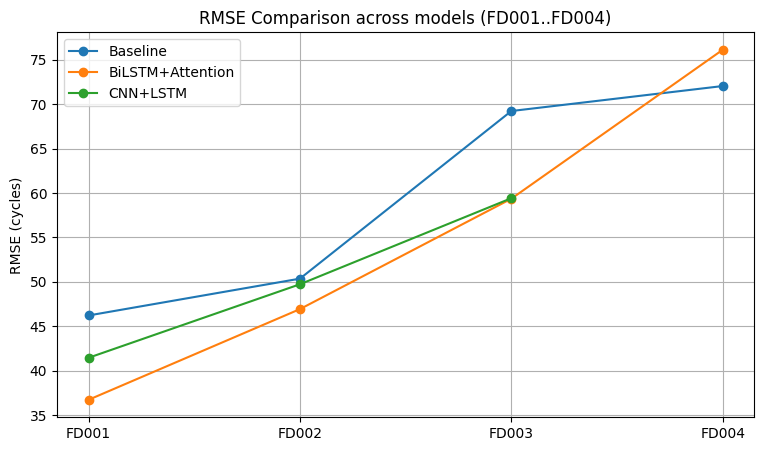

In [10]:
# 🔧 Build results_* dictionaries from the summary CSVs (run after ALL model cells finish)
import pandas as pd, numpy as np, matplotlib.pyplot as plt

base_csv = "/content/orca_outputs/cmapss_results_summary.csv"
deep_csv = "/content/orca_outputs/cmapss_results_summary_deep.csv"
attn_csv = "/content/orca_outputs/cmapss_results_summary_attn.csv"

def csv_to_result_dict(path):
    df = pd.read_csv(path)
    out = {}
    for _, r in df.iterrows():
        fd = r["FD"] if "FD" in r else f"FD{int(r['FD_ID']):03d}"
        # support either column names MAE_cycles / RMSE_cycles or MAE / RMSE
        mae = r.get("MAE_cycles", r.get("MAE", np.nan))
        rmse = r.get("RMSE_cycles", r.get("RMSE", np.nan))
        out[fd] = {"MAE": float(mae) if not pd.isna(mae) else None,
                   "RMSE": float(rmse) if not pd.isna(rmse) else None}
    return out

# create the three dicts
results_baseline = csv_to_result_dict(base_csv)
results_cnn_lstm = csv_to_result_dict(deep_csv)
results_bilstm_attention = csv_to_result_dict(attn_csv)

# quick sanity checks
print("Has baseline keys:", list(results_baseline.keys())[:10])
print("Has cnn_lstm keys:", list(results_cnn_lstm.keys())[:10])
print("Has attn keys:", list(results_bilstm_attention.keys())[:10])

# --- now create the comparison DataFrame and plots ---
all_results = []
for name, res in [
    ("Baseline", results_baseline),
    ("CNN+LSTM", results_cnn_lstm),
    ("BiLSTM+Attention", results_bilstm_attention),
]:
    for fd, metrics in res.items():
        all_results.append({
            "Model": name,
            "FD": fd,
            "MAE": metrics.get("MAE"),
            "RMSE": metrics.get("RMSE")
        })

df_results = pd.DataFrame(all_results).sort_values(["FD","Model"]).reset_index(drop=True)
print("\nComparison table (MAE):")
display(df_results.pivot(index="FD", columns="Model", values="MAE"))

# Plot MAE
plt.figure(figsize=(9,5))
for model in df_results["Model"].unique():
    sub = df_results[df_results["Model"]==model]
    plt.plot(sub["FD"], sub["MAE"], marker="o", label=model)
plt.title("MAE Comparison across models (FD001..FD004)")
plt.ylabel("MAE (cycles)")
plt.legend()
plt.grid(True)
plt.show()

# Plot RMSE
plt.figure(figsize=(9,5))
for model in df_results["Model"].unique():
    sub = df_results[df_results["Model"]==model]
    plt.plot(sub["FD"], sub["RMSE"], marker="o", label=model)
plt.title("RMSE Comparison across models (FD001..FD004)")
plt.ylabel("RMSE (cycles)")
plt.legend()
plt.grid(True)
plt.show()
